# Notebook to showcase the basic functioning of the wfc3_dash module

## Imports

* *astroquery.mast Observations* used to download IMA files from the MAST HST archive
* *astropy.io import fits* used to open the files
* *matplotlib.pyplot* used to plot the images
* *numpy* used for some math

In [26]:
from astroquery.mast import Observations
from astropy.io import fits 
from astropy.table import Table
import matplotlib.pyplot as plt 
import numpy as np 

%matplotlib notebook 

## Introduction

The wfc3_dash submodule of wfc3_tools is used to reduce the effects of the spacecraft drift for WFC3/IR images taken in DASH mode (i.e. under GYRO control, rather than under Fine-Guide-Sensor control) 

This notebook works on a single .flt file but can be easily adapted to work on all exposures within a DASH visit or even a DASH program

## Downloading some relevant data

#### Get the table of observations associated to GO-14114 (PI van Dokkum, the first proposal to use the DASH mode)

In [2]:
obsTable = Observations.query_criteria(proposal_id=['14114'])

#### Get the full list of products associated to the table and restric the list to IMA files

In [3]:
product_list = Observations.get_product_list(obsTable)
BM = (product_list['productSubGroupDescription']  == 'IMA') 
product_list = product_list[BM]

#### Display (part of) the IMA files list

In [4]:
product_list.show_in_notebook(display_length=5)

#### Pick a single exposure file to work on

In [5]:
myID = product_list['obsID'][0:1]

#### Download the IMA and FLT files for that exposure. The standard pipeline-FLT will be used for comparison with the detrended final product

In [6]:
download = Observations.download_products(myID,mrp_only=False,productSubGroupDescription=['IMA','FLT'])

INFO: Found cached file ./mastDownload/HST/icxe01tyq/icxe01tyq_ima.fits with expected size 126201600. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/icxe01tyq/icxe01tyq_flt.fits with expected size 16534080. [astroquery.query]


#### Display the results of the download operation

In [7]:
download

<Table length=2>
                   Local Path                    Status  Message  URL  
                     str47                        str8    object object
----------------------------------------------- -------- ------- ------
./mastDownload/HST/icxe01tyq/icxe01tyq_ima.fits COMPLETE    None   None
./mastDownload/HST/icxe01tyq/icxe01tyq_flt.fits COMPLETE    None   None

#### Read the files that were just downloaded locally 

In [8]:
localpathtofile = download['Local Path'][0][:-8]
localpathtofile

original_ima = fits.open(localpathtofile+'ima.fits')
original_flt = fits.open(localpathtofile+'flt.fits')
original_ima.info()

Filename: ./mastDownload/HST/icxe01tyq/icxe01tyq_ima.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     260   ()      
  1  SCI           1 ImageHDU        81   (1024, 1024)   float32   
  2  ERR           1 ImageHDU        43   (1024, 1024)   float32   
  3  DQ            1 ImageHDU        35   (1024, 1024)   int16   
  4  SAMP          1 ImageHDU        30   ()      
  5  TIME          1 ImageHDU        30   ()      
  6  SCI           2 ImageHDU        81   (1024, 1024)   float32   
  7  ERR           2 ImageHDU        43   (1024, 1024)   float32   
  8  DQ            2 ImageHDU        35   (1024, 1024)   int16   
  9  SAMP          2 ImageHDU        30   ()      
 10  TIME          2 ImageHDU        30   ()      
 11  SCI           3 ImageHDU        81   (1024, 1024)   float32   
 12  ERR           3 ImageHDU        43   (1024, 1024)   float32   
 13  DQ            3 ImageHDU        35   (1024, 1024)   int16   
 14  SAMP          

#### Plot the individual reads of the IMA file
Note: the individual 'SCI' extensions are stored in reverse order, with 'SCI', 1 corresponding to the last read

NSAMP 12


<IPython.core.display.Javascript object>


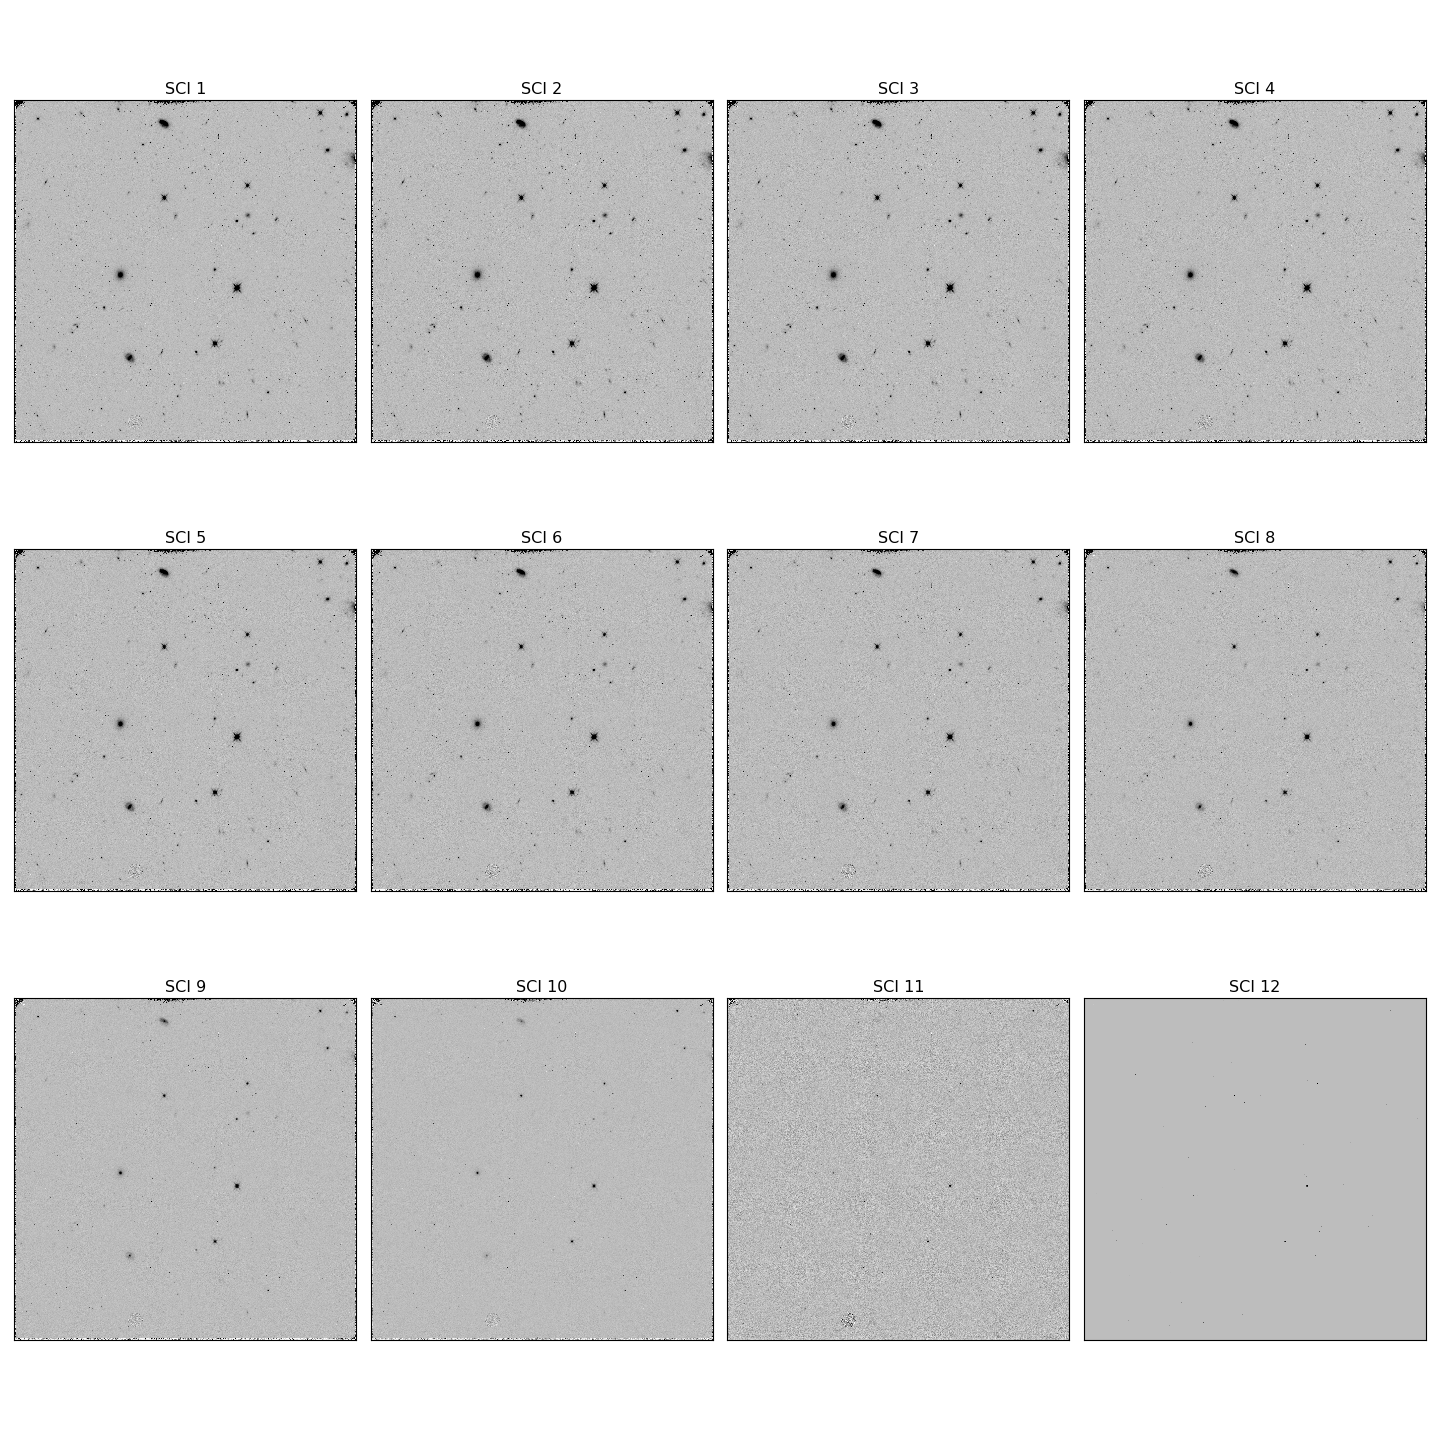

In [9]:
nsamp = original_ima[0].header['NSAMP']
print('NSAMP',nsamp)
fig,axarr = plt.subplots((nsamp+3)//4,4, figsize=(18,6*((nsamp+3)//4)))

for i in range(1,4*((nsamp+3)//4)+1):

    row = (i-1)//4
    col = (i-1)%4
    if (i <= nsamp+1):
        immed = np.nanmedian(original_ima['SCI',i].data)
        stdev = np.nanstd(original_ima['SCI',i].data)
        axarr[row,col].imshow(original_ima['SCI',i].data,clim=[immed-.3*stdev,immed+.5*stdev],cmap='Greys',origin='lower')
        axarr[row,col].set_title('SCI '+str(i))
        axarr[row,col].set_xticks([]) 
        axarr[row,col].set_yticks([]) 
    else:
        fig.delaxes(axarr[row,col])

fig.tight_layout()

## Run the individual steps of the DASH pipeline

#### This cell is inserted temporarely to allow for relative imports until the whole wfc3_dash submodule is properly packaged and installed within the wfc3_tools module

In [10]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from reduce_dash import DashData

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol


### 1. Create a DashData object using the path to the ima file we have downloaded above

In [11]:
myDash = DashData(localpathtofile+'ima.fits')

### 2. create diff files. 

A diff file contains the counts accumulated between two reads.  
The diff files are written to disk in a directory named ./diff under the current working directory (cwd).  
In creating diff files, the first difference, between the 1-st and 0-th read is ignored becuase of   
its very short expsoure time of 2.9 seconds, resulting in a noisy image.

In order to create a correct error extension, the split_ima() method calls the utils.get_flat() function.  
Such function reads the name of the flat field used for calibrating the ima images from the ima file header.  
If the flat file is not present locally in a directory named ./iref under the cwd, get_flat() will download   
the flat field file from the CRDS database https://hst-crds.stsci.edu/unchecked_get/references/hst/ 
and place it in ./iref .

In [12]:
myDash.split_ima()

Writing icxe01tyq_01_diff.fits
Writing icxe01tyq_02_diff.fits
Writing icxe01tyq_03_diff.fits
Writing icxe01tyq_04_diff.fits
Writing icxe01tyq_05_diff.fits
Writing icxe01tyq_06_diff.fits
Writing icxe01tyq_07_diff.fits
Writing icxe01tyq_08_diff.fits
Writing icxe01tyq_09_diff.fits
Writing icxe01tyq_10_diff.fits


#### Plot the diff files

Number of diff files 10


<IPython.core.display.Javascript object>


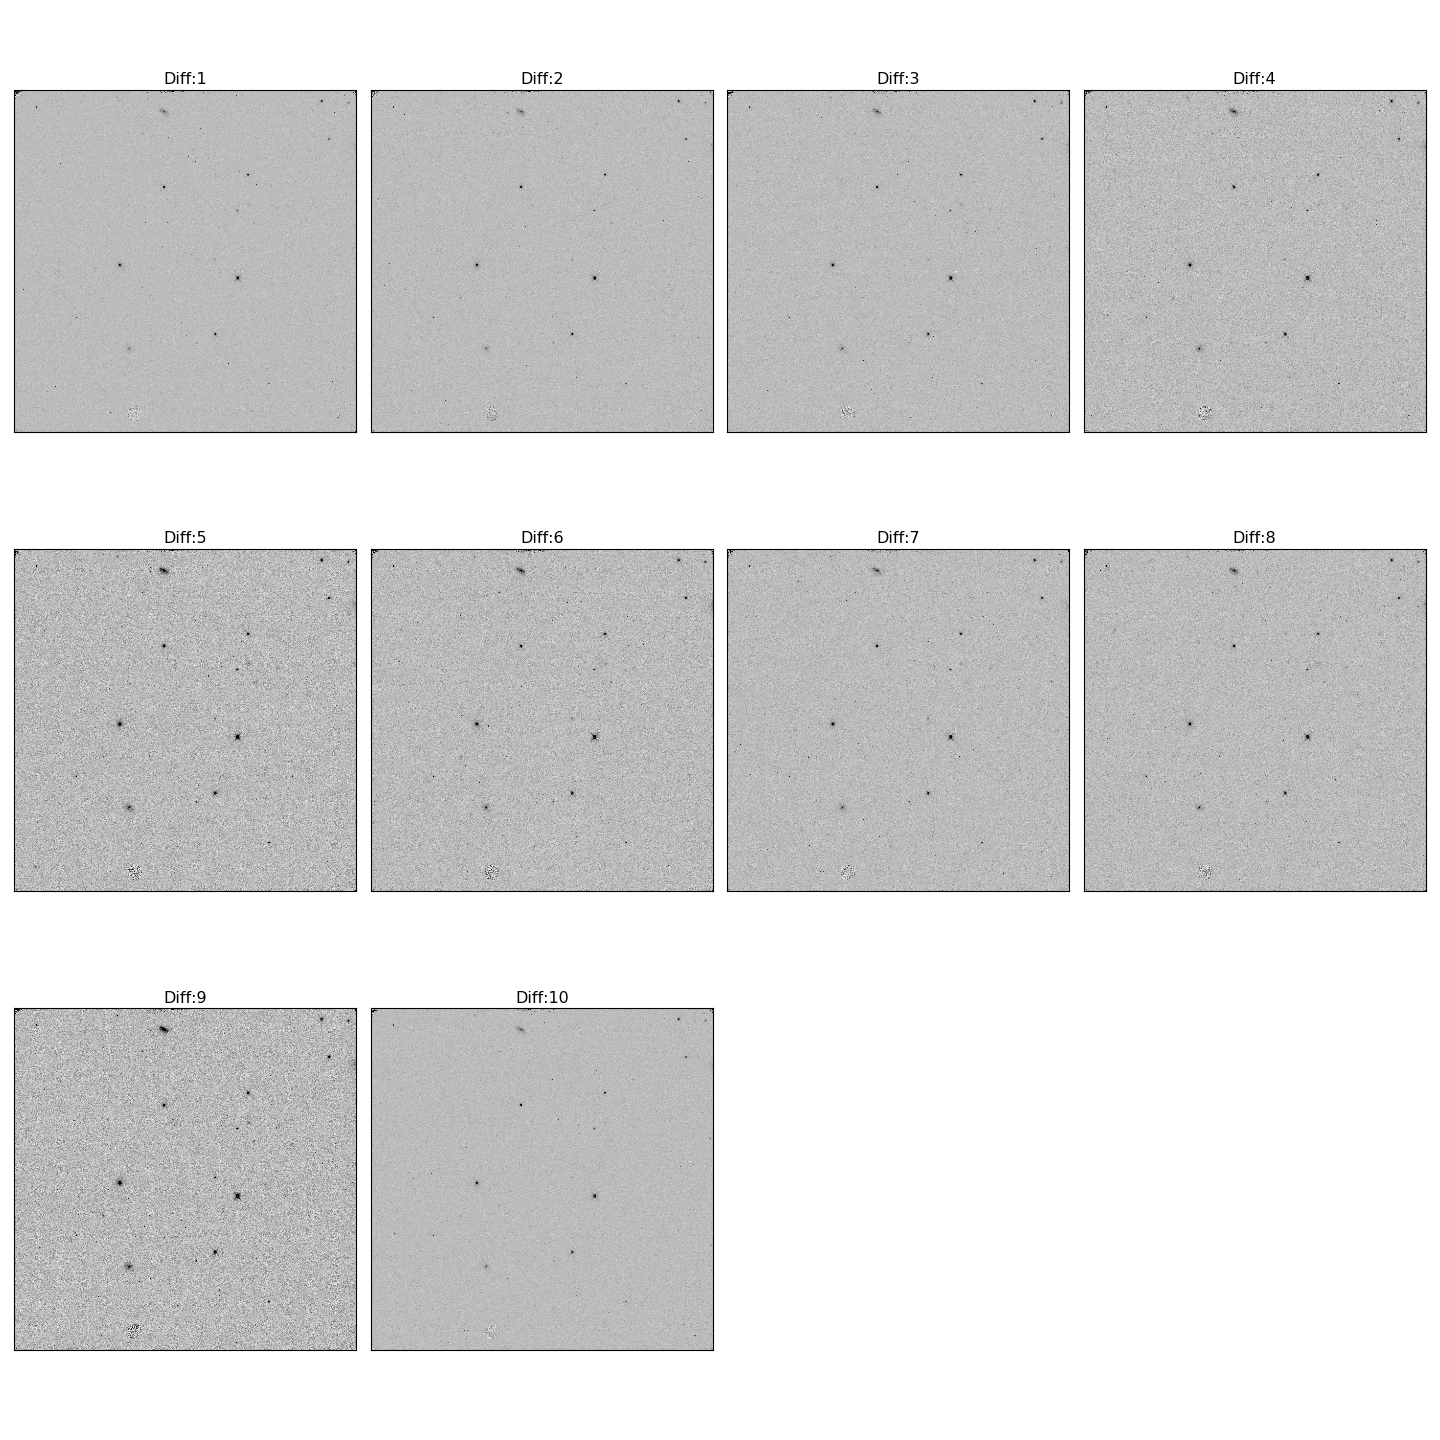

In [14]:
ndiff = len(myDash.diff_files_list)
print('Number of diff files',ndiff)
fig,axarr = plt.subplots((ndiff+3)//4,4, figsize=(18,6*((ndiff+3)//4)))

for i in range(4*((ndiff+3)//4)):

    row = (i)//4
    col = (i)%4
    if (i < ndiff):
        diff_i = fits.open(myDash.diff_files_list[i]+'_diff.fits')
        immed = np.nanmedian(diff_i['SCI'].data)
        stdev = np.nanstd(diff_i['SCI'].data)
        axarr[row,col].imshow(diff_i['SCI'].data,clim=[immed-.3*stdev,immed+.5*stdev],cmap='Greys',origin='lower')
        axarr[row,col].set_title('Diff:'+str(i+1))
        axarr[row,col].set_xticks([]) 
        axarr[row,col].set_yticks([]) 
    else:
        fig.delaxes(axarr[row,col])

fig.tight_layout()

### 3. Create an association file

This file mimics a typical association file for dithered exposures, that is used by astrodrizzle   
to align and stack multiple exposures taken at the same sky position with small dithers.  
We exploit the fact that a WFC3/IR exposure taken under gyro control can be effectively split into   
individual pseudo-exposures (the diff images).  
Astrodrizzle can treat such pseudo-expsoures as individual dithers, and comnbine them.

In [22]:
myDash.make_pointing_asn()



FITS_rec([('diff/icxe01tyq', 'EXP-DTH', True),
       ('diff/icxe01tyq', 'EXP-DTH', True),
       ('diff/icxe01tyq', 'EXP-DTH', True),
       ('diff/icxe01tyq', 'EXP-DTH', True),
       ('diff/icxe01tyq', 'EXP-DTH', True),
       ('diff/icxe01tyq', 'EXP-DTH', True),
       ('diff/icxe01tyq', 'EXP-DTH', True),
       ('diff/icxe01tyq', 'EXP-DTH', True),
       ('diff/icxe01tyq', 'EXP-DTH', True),
       ('diff/icxe01tyq', 'EXP-DTH', True),
       ('icxe01tyq', 'PROD-DTH', False)], 
      dtype=(numpy.record, [('MEMNAME', 'S14'), ('MEMTYPE', 'S14'), ('MEMPRSNT', 'i1')]))

#### Show the content of the asn file

In [27]:
asn_filename = 'diff/{}_asn.fits'.format(myDash.root)
asn_table = Table(fits.getdata(asn_filename, ext=1))
asn_table.show_in_notebook()